Disentangled representations with $\beta$-VAE and forced learning of some traits for Radio Galaxies

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils import data
from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR

from torchvision import transforms
from torchvision import datasets

import numpy as np

from matplotlib import pyplot as plt
from pandas import read_fwf, DataFrame
from tqdm   import tqdm_notebook as tqdm
import matplotlib.gridspec as gridspec


from skimage import exposure
from skimage import measure
from skimage.io import imsave
from skimage.filters import gaussian as gaussian_filter
from skimage.filters import threshold_otsu
from skimage import filters
from skimage.morphology import opening, closing, disk, binary_dilation, flood

In [2]:
sys.path.append('../')
from VAE.rg_dataset import LRG, BasicDataset
from VAE.vae_models import VAE

In [3]:
%%time
data_path = '../data/'
aug=15
lrg_data_set   = LRG(use_kittler=True, n_aug=aug, blur=False, catalog_dir=data_path + 'catalog/mrt-table3.txt', 
                                                               file_dir=data_path + 'lrg')

unlrg_data_set = LRG(use_kittler=True, n_aug=aug, blur=False, catalog_dir=data_path + 'catalog/mrt-table4.txt',
                                                               file_dir=data_path + 'unlrg')

../data/lrg:	1442/1442
../data/unlrg:	14245/14245
CPU times: user 6min 9s, sys: 6min 41s, total: 12min 51s
Wall time: 4min 18s


In [4]:
batch_size = 128
data_loader_lrg   = data.DataLoader(lrg_data_set,   batch_size=batch_size, shuffle=False)
data_loader_unlrg = data.DataLoader(unlrg_data_set, batch_size=batch_size, shuffle=True)

sample = iter(data_loader_lrg).next()

In [5]:
# data_path = '../data/'

# lrg_images   = np.load(data_path+'proc_aligned2/lrg_norm_proc.npy', allow_pickle=True)
# unlrg_images = np.load(data_path+'proc_aligned2/unlrg_norm_proc.npy', allow_pickle=True)

# aug=15

# my_lrg_dataset  = BasicDataset(lrg_images, lrg_data_set.labels, n_aug=10) #
# my_unlrg_dataset  = BasicDataset(unlrg_images, unlrg_data_set.labels, n_aug=aug)

# batch_size = 128
# data_loader_lrg   = data.DataLoader(my_lrg_dataset,   batch_size=batch_size, shuffle=False)
# data_loader_unlrg = data.DataLoader(my_unlrg_dataset, batch_size=batch_size, shuffle=True)

# sample = iter(data_loader_lrg).next()

In [6]:
def make_vae_loss(KLD_weight=1):
    def vae_loss(output, target, KLD_weight=KLD_weight):
        """loss is BCE + KLD. target is original x"""
        recon_x, mu_logvar  = output
        mu = mu_logvar[:, 0:int(mu_logvar.size()[1]/2)]
        logvar = mu_logvar[:, int(mu_logvar.size()[1]/2):]
        KLD = -0.5 * torch.sum(1 + 2 * logvar - mu.pow(2) - (2 * logvar).exp())
        BCE = F.mse_loss(recon_x, target, reduction='sum')
        loss = BCE + KLD_weight*KLD
        return loss
    return vae_loss

In [7]:
#Simple Variational Auto Encoder
class VAE(nn.Module):
    def __init__(self, lt_dim=4, use_STN=True, batchNorm=True, dropout=True, activation_fnc = nn.ReLU):
        super(VAE, self).__init__()
        self.k = [1, 16, 32, 64, 128, 256]
        encoder_layers = []
        decoder_layers = []
        ####################### STN STUFF ###################
        self.use_STN = use_STN
        final_size = 1
        final_bias = torch.cuda.FloatTensor([0])
        
        self.batch_opt_params = {"num_times" : 20, "iterations" : 10 }

        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.AdaptiveMaxPool2d(output_size=(3, 3)),
            nn.ReLU(True)
        )
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, final_size)
        )
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(final_bias)

        self.activation_fnc = activation_fnc
        # initialize to identity for rotation or affine
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(final_bias)
        #####################################################
        for i in range(len(self.k) - 1):
            layer = nn.Conv2d(self.k[i], self.k[i+1], 3, 2, 1, 1)
            encoder_layers.append(layer)
            if batchNorm: 
                encoder_layers.append(nn.BatchNorm2d(self.k[i+1]))
            encoder_layers.append(self.activation_fnc())
            if dropout:
                encoder_layers.append(nn.Dropout2d())

        
        for i in range(len(self.k) - 1, 0, -1):
            layer = nn.ConvTranspose2d(self.k[i], self.k[i-1], 3, 2, 1, 1)
            decoder_layers.append(layer)
            if i == 1:
                continue
            if batchNorm: 
                decoder_layers.append(nn.BatchNorm2d(self.k[i - 1]))
            decoder_layers.append(self.activation_fnc())
            if dropout:
                decoder_layers.append(nn.Dropout2d())


        self.encoder = nn.Sequential(*encoder_layers)
        self.decoder = nn.Sequential(*decoder_layers)
        
        self.fc_mu = nn.Sequential(
                      nn.Linear(self.k[-1]*2*2, lt_dim*2),
                      nn.Linear(lt_dim*2, lt_dim)
        )
        self.fc_ep = nn.Sequential(
                      nn.Linear(self.k[-1]*2*2, lt_dim*2),
                      nn.Linear(lt_dim*2, lt_dim)
        )
        
        self.fc_dc = nn.Linear(lt_dim, self.k[-1]*2*2)
    
    def get_stn_params(self, x):
        x = self.localization(x)
        x = x.view(-1, 10 * 3 * 3)
        stn_output = self.fc_loc(x)

        affine_params = torch.cuda.FloatTensor(stn_output.size()[0], 2, 3).fill_(0)
#         print('-------------------------------------')
#         print(affine_params.shape, stn_output.shape)
        affine_params = self.theta_to_affine(stn_output, affine_params)

        return affine_params

    def theta_to_affine(self, theta, affine_params):
#         print(affine_params[:, 0, 0].shape, torch.cos(theta)[:,0].shape)
        affine_params[:, 0, 0] = torch.cos(theta)[:,0]
        affine_params[:, 0, 1] = torch.sin(theta)[:,0]
        affine_params[:, 1, 0] = -1*torch.sin(theta)[:,0]
        affine_params[:, 1, 1] = torch.cos(theta)[:,0]
        return affine_params

    def affine(self, x, affine_params, padding_mode='zeros'):
        grid = F.affine_grid(affine_params, x.size()).cuda()
        x = F.grid_sample(x, grid, padding_mode=padding_mode)
        return x
    
    def affine_inv(self, x, affine_params, padding_mode='zeros'):
        inv_affine_params = torch.cuda.FloatTensor(affine_params.size()).fill_(0)
        A_inv =  torch.inverse(affine_params[:, :, :2].squeeze())
        b = affine_params[:, : , 2:]
        b_inv = torch.matmul(A_inv, b)
        b_inv = b_inv.squeeze()
        inv_affine_params[:, :2, :2] = A_inv
        inv_affine_params[:, :, 2]   = -1 * b_inv
        grid = F.affine_grid(inv_affine_params, x.size()).cuda()
        x = F.grid_sample(x, grid, padding_mode=padding_mode)
        return x


    def encode(self, x):
        affine_params = self.get_stn_params(x)
        
        

        self.affine_params = affine_params
        x = self.affine(x, self.affine_params)

        encoded = self.encoder(x).view(-1, self.k[-1]*2*2)
        return self.fc_mu(encoded), self.fc_ep(encoded)
    
    def reparameterize(self, mu, logvar):
        if self.training :
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return mu + eps*std
        else :
            return mu

    def decode(self, x):
        x = F.relu(self.fc_dc(x)).view(-1, self.k[-1], 2, 2)
        x = torch.sigmoid(self.decoder(x))
        if self.use_STN:
            x = self.affine_inv(x, self.affine_params)
        return x

    def forward(self, x, return_affine=False):
        mu, var = self.encode(x)
        z = self.reparameterize(mu, var)
        d = self.decode(z)
        if return_affine:
            return d, mu, var, self.affine(x, self.affine_params)
        return d, mu, var

In [8]:
class B_VAE_Loss:
    def __init__(self, gamma, max_capacity, epochs):
        self.gamma = gamma
        self.recon_ls = nn.BCELoss(reduction='sum')
        self.capacity = 0
        self.delta = max_capacity / float(epochs)
        self.max_capacity = max_capacity
    def update(self):
        self.capacity = min(self.max_capacity, self.capacity + self.delta)
        return self.capacity
    def __call__(self, res, img):
        batch_sz = len(img)
        x, mu, logvar = res
        recon = self.recon_ls(x, img).div(batch_sz) #res -> x, mu, var
        kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()).div(batch_sz)
        return self.capacity, recon, self.gamma * (kld - self.capacity).abs()

In [9]:
def train_step(model, device, data_loader, optim, epoch, log_interval=5):
    model.train()
    s = ''
    for batch_idx, (data, target) in enumerate(data_loader):
        data = data.to(device)
        target = Variable(target, requires_grad=False).to(device)
        #Forward Pass
        optimizer.zero_grad()
        output = model(data)
        
        #############################################
        ######### check against known class #########
        #############################################
        #########    Compact vs Extended    #########
        extended = target > 1
        extended = Variable(extended.float().to(device), requires_grad=False)
        pred_ext = torch.sigmoid(output[1][:,0])
        ext_loss = F.binary_cross_entropy(pred_ext, extended, reduction='sum').div(len(pred_ext))
        # BCE Loss
        c, r_loss , g_loss = beta_vae_loss(output, data)
        loss = r_loss + g_loss + 10 * (ext_loss)#+ fr_loss)# + reg_loss)
        #Backpropagation
        loss.backward()
        optimizer.step()
        s = 'Train Epoch: {:3d} ({:3.0f}%)  Loss: {:4.4f}  R_Loss: {:4.4f}  Capacity: {:4.2f}'
        s = s.format(epoch,
                100. * batch_idx / len(data_loader), loss.item(), r_loss.item(), c)
        if batch_idx % log_interval == 0:
            sys.stdout.write('{}\r'.format(s))
            sys.stdout.flush()
    return s

In [10]:
def test_step(model, device, data_loader, optim, epoch, log_interval=5):
    model.eval()
    loss = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        with torch.no_grad():
            data = data.to(device)
            #Forward Pass
            output = model(data)

            # BCE Loss
            c, r_loss , g_loss = beta_vae_loss(output, data)
            loss = r_loss
    return loss

In [11]:
device = 'cuda'
lt_dim = 10
lr= 0.0001
lambda_lr = lambda epoch : np.power(0.75, epoch / 5)
epochs = 50
gam = 10
cap = 10
beta_vae_loss = B_VAE_Loss(gamma=gam, max_capacity=cap, epochs=epochs)

In [12]:
def do_training(vae, optimizer, scheduler):
    for epoch in range(1, epochs+1):
        #LRG, forced params
        start = time.time()
        s = train_step(vae, 'cuda', data_loader_unlrg, optimizer, epoch)
        loss = test_step(vae, 'cuda', data_loader_lrg, optimizer, epoch)
        t = time.time() - start
        sys.stdout.write('{}   Test Loss : {:4.4f}   Time : {:.2f}s   LR: {}\n'.format(s, loss, t, scheduler.get_lr()[0]))
        beta_vae_loss.update()

#         scheduler.step()

In [78]:
# vae = VAE(lt_dim=lt_dim, use_STN=True, activation_fnc=nn.ELU).to(device)

# data, target =  iter(data_loader_lrg).next()
# vae.encode(data.to(device))

In [79]:
%%time
k = [1, 16, 16, 32, 32, 64]
vae = VAE(lt_dim=lt_dim, use_STN=True, activation_fnc=nn.ELU, k=k).to(device)
optimizer = Adam(vae.parameters(), lr=lr, weight_decay=1E-5)

scheduler = LambdaLR(optimizer, lr_lambda= lambda_lr)
do_training(vae, optimizer, scheduler)
torch.save(vae, 'b_vae_soft_stn_elu')

Train Epoch:   1 (100%)  Loss: 1242.1206  R_Loss: 1235.1730  Capacity: 0.00   Test Loss : 1118.7977   Time : 112.07s   LR: 0.0001
Train Epoch:   2 (100%)  Loss: 441.6462  R_Loss: 435.8616  Capacity: 0.20   Test Loss : 458.7677   Time : 110.98s   LR: 0.0001
Train Epoch:   3 (100%)  Loss: 288.8086  R_Loss: 282.1199  Capacity: 0.40   Test Loss : 292.9392   Time : 110.80s   LR: 0.0001
Train Epoch:   4 (100%)  Loss: 207.5100  R_Loss: 200.2396  Capacity: 0.60   Test Loss : 259.1708   Time : 110.27s   LR: 0.0001
Train Epoch:   5 (100%)  Loss: 135.8594  R_Loss: 130.7463  Capacity: 0.80   Test Loss : 229.3895   Time : 110.43s   LR: 0.0001
Train Epoch:   6 (100%)  Loss: 106.1451  R_Loss: 99.2886  Capacity: 1.00   Test Loss : 222.2885   Time : 110.52s   LR: 0.0001
Train Epoch:   7 (100%)  Loss: 108.8278  R_Loss: 101.2480  Capacity: 1.20   Test Loss : 210.3911   Time : 110.13s   LR: 0.0001
Train Epoch:   8 (100%)  Loss: 94.1545  R_Loss: 87.5673  Capacity: 1.40   Test Loss : 202.9116   Time : 109.9

(-0.5, 63.5, 63.5, -0.5)

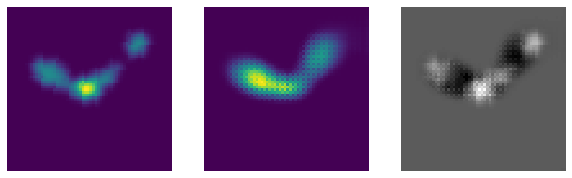

In [80]:
a = 1
vae.eval()
s, l = sample[0][a:a+1], sample[1][a:a+1]
with torch.no_grad():
    e = vae.encode(s.to(device))[0]
    d = vae.decode(e)
f, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(s[0][0])
ax[1].imshow(d.cpu()[0][0])
ax[2].imshow(s[0][0] - d.cpu()[0][0], cmap='gray')
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')

In [13]:
%%time
vae = VAE(lt_dim=lt_dim, use_STN=True, dropout= False, activation_fnc=nn.ELU).to(device)
optimizer = Adam(vae.parameters(), lr=lr, weight_decay=1E-5)

scheduler = LambdaLR(optimizer, lr_lambda= lambda_lr)
do_training(vae, optimizer, scheduler)
torch.save(vae, 'b_vae_soft_stn_elu_nodrop')

Train Epoch:   1 (100%)  Loss: 218.4381  R_Loss: 211.0197  Capacity: 0.00   Test Loss : 328.0204   Time : 109.73s   LR: 0.0001
Train Epoch:   2 (100%)  Loss: 140.5859  R_Loss: 133.7599  Capacity: 0.20   Test Loss : 240.9024   Time : 108.65s   LR: 0.0001
Train Epoch:   3 (100%)  Loss: 103.3583  R_Loss: 97.1330  Capacity: 0.40   Test Loss : 223.9492   Time : 109.07s   LR: 0.0001
Train Epoch:   4 (100%)  Loss: 94.5880  R_Loss: 88.4220  Capacity: 0.60   Test Loss : 215.4087   Time : 108.24s   LR: 0.0001
Train Epoch:   5 (100%)  Loss: 148.2065  R_Loss: 136.0288  Capacity: 0.80   Test Loss : 208.3745   Time : 107.77s   LR: 0.0001
Train Epoch:   6 (100%)  Loss: 89.8563  R_Loss: 84.6839  Capacity: 1.00   Test Loss : 199.7004   Time : 109.41s   LR: 0.0001
Train Epoch:   7 (100%)  Loss: 70.6879  R_Loss: 65.4453  Capacity: 1.20   Test Loss : 191.4524   Time : 111.06s   LR: 0.0001
Train Epoch:   8 (100%)  Loss: 86.7403  R_Loss: 81.4278  Capacity: 1.40   Test Loss : 189.0792   Time : 107.87s   LR: 

(-0.5, 63.5, 63.5, -0.5)

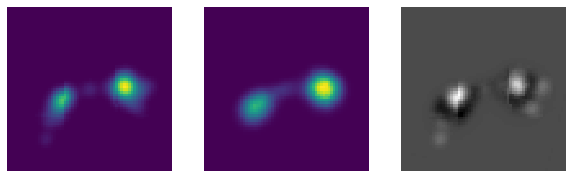

In [83]:
a = 22
vae.eval()
s, l = sample[0][a:a+1], sample[1][a:a+1]
with torch.no_grad():
    e = vae.encode(s.to(device))[0]
    d = vae.decode(e)
f, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(s[0][0])
ax[1].imshow(d.cpu()[0][0])
ax[2].imshow(s[0][0] - d.cpu()[0][0], cmap='gray')
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')

In [49]:
vae.affine_params

tensor([[[ 0.9924, -0.1234,  0.0000],
         [ 0.1234,  0.9924,  0.0000]]], device='cuda:0')

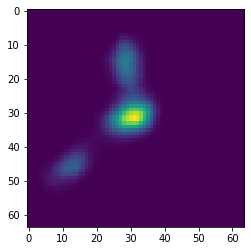

tensor([[ 2.7791, -0.1545,  2.6928,  3.7952,  1.1227,  1.5732,  1.8288,  0.4163,
         -0.5172,  2.0611]], device='cuda:0')


In [92]:
vae = torch.load('b_vae_soft_stn_elu_nodrop')
vae.eval()

a = 1
s, l = sample[0][a:a+1], sample[1][a:a+1]
p = np.rot90(s[0][0].numpy())
rs = torch.tensor(np.array([[p]]))
with torch.no_grad():
    e = vae(rs.to(device), return_affine=True)
    
plt.imshow(e[0][0][0].cpu())
plt.show()

print(e[1])

In [91]:
e[1]

tensor([[ 2.8979,  0.5700, -2.6591, -2.1423,  1.3470,  1.9478,  2.1379,  0.8741,
         -1.0725,  0.1313]], device='cuda:0')

In [62]:
%%time
vae = VAE(lt_dim=lt_dim, use_STN=True, dropout= False, batchNorm=False, activation_fnc=nn.ELU).to(device)
optimizer = Adam(vae.parameters(), lr=lr, weight_decay=1E-5)

scheduler = LambdaLR(optimizer, lr_lambda= lambda_lr)
do_training(vae, optimizer, scheduler)
torch.save(vae, 'b_vae_soft_stn_elu_nodrop_nonorm')

In [ ]:
a = 1
vae.eval()
s, l = sample[0][a:a+1], sample[1][a:a+1]
with torch.no_grad():
    e = vae.encode(s.to(device))[0]
    d = vae.decode(e)
f, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(s[0][0])
ax[1].imshow(d.cpu()[0][0])
ax[2].imshow(s[0][0] - d.cpu()[0][0], cmap='gray')
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')

In [ ]:
%%time
vae = VAE(lt_dim=lt_dim, use_STN=False, activation_fnc=nn.ELU).to(device)
optimizer = Adam(vae.parameters(), lr=lr, weight_decay=1E-5)

scheduler = LambdaLR(optimizer, lr_lambda= lambda_lr)
do_training(vae, optimizer, scheduler)
torch.save(vae, 'b_vae_soft_elu')

In [ ]:
%%time
vae = VAE(lt_dim=lt_dim, use_STN=False, dropout= False, activation_fnc=nn.ELU).to(device)
optimizer = Adam(vae.parameters(), lr=lr, weight_decay=1E-5)

scheduler = LambdaLR(optimizer, lr_lambda= lambda_lr)
do_training(vae, optimizer, scheduler)
torch.save(vae, 'b_vae_soft_stn_elu_nodrop')

In [ ]:
%%time
vae = VAE(lt_dim=lt_dim, use_STN=False, dropout= False, batchNorm=False, activation_fnc=nn.ELU).to(device)
optimizer = Adam(vae.parameters(), lr=lr, weight_decay=1E-5)

scheduler = LambdaLR(optimizer, lr_lambda= lambda_lr)
do_training(vae, optimizer, scheduler)
torch.save(vae, 'b_vae_soft_stn_elu_nodrop_nonorm')